In [3]:
# config
import os
import torch
import numpy as np
import pandas as pd
from transformers import AutoTokenizer, BertTokenizer
from torch.utils.data import Dataset, DataLoader, Sampler
from transformers import BertModel, AutoModel
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from time import time, localtime, strftime
from bisect import bisect
from functools import cmp_to_key
import json
import matplotlib.pyplot as plt
# /home/drkocharyan/ai4code/AI4Code



In [4]:
from torch.cuda.amp import autocast, GradScaler


In [5]:
config = {
    "data_path": "/home/drkocharyan/ai4code/AI4Code/train/",
    "train_orders_path": "/home/drkocharyan/ai4code/AI4Code/train_orders.csv",
    
    "code_model_name": "microsoft/codebert-base",
    "text_model_name": "bert-base-multilingual-uncased",
    
    "train_size": 0.7,
    "valid_size": 0.2,
    "test_size": 0.1,
    "random_seed": 42,
    
    "train_samples": 90000,
    "valid_samples": 5000,
    "test_samples": 2000,
    
    "hidden_dim": 128,
    "dropout_prob": 0.1,
    "max_length": 128,
    
    "batch_size": 64,
    "epochs": 5,
    "early_stopping": 5,
    "saving_freq": 5,
    "learning_rate": 1e-4
}

In [6]:
# utils
def prepare_folders():
    current_time = strftime("%d.%m.%Y-%H.%M", localtime())
    savedir = f"./checkpoints/{current_time}/"

    if not os.path.exists("./checkpoints"):
        os.mkdir("./checkpoints/")
    if not os.path.exists(savedir):
        os.mkdir(savedir)
    else:
        for root, dirs, files in os.walk(savedir, topdown=False):
            for name in files:
                os.remove(os.path.join(root, name))
            for name in dirs:
                os.rmdir(os.path.join(root, name))

    return savedir


def get_device():
    device = "cuda" if torch.cuda.is_available() else "mps" if torch.mps.is_available() else "cpu"
    return device


def count_inversions(a):
    inversions = 0
    sorted_so_far = []
    for i, u in enumerate(a):
        j = bisect(sorted_so_far, u)
        inversions += i - j
        sorted_so_far.insert(j, u)
    return inversions


def kendall_tau(ground_truth, predictions):
    total_inversions = 0
    total_2max = 0
    for gt, pred in zip(ground_truth, predictions):
        ranks = [gt.index(x) for x in pred]
        total_inversions += count_inversions(ranks)
        n = len(gt)
        total_2max += n * (n - 1)
    return 1 - 4 * total_inversions / total_2max


In [7]:
# Datasets

class Cell:
    def __init__(self, input_ids, att_mask, cell_type):
        self.input_ids = input_ids
        self.att_mask = att_mask
        self.cell_type = cell_type

    def get(self):
        return (self.input_ids, self.att_mask, self.cell_type)


class CellDataset(Dataset):
    def __init__(self, path, data, code_tokenizer, text_tokenizer, max_length):
        self.data = data
        self.code_tokenizer = code_tokenizer
        self.text_tokenizer = text_tokenizer
        self.max_length = max_length
        self.files = {}

        for filename in tqdm(self.data.index, desc="Processing dataset"):
            cells_dict = {}
            cells = self.data.loc[filename, "cell_order"]
            with open(f"{path}{filename}.json") as file:
                json_code = json.load(file)
            for cell in cells:
                input_ids, att_mask, cell_type = self.prepare_data(
                    json_code["cell_type"][cell], json_code["source"][cell]
                )
                cells_dict[cell] = Cell(input_ids, att_mask, cell_type)
            self.files[filename] = cells_dict

    def __len__(self):
        pass

    def __getitem__(self, idx):
        pass

    def prepare_data(self, cell_type, cell_content):
        if cell_type == "code":
            tokenizer = self.code_tokenizer
            type_label = 1
        else:
            tokenizer = self.text_tokenizer
            type_label = 0

        tokens = tokenizer(
            cell_content,
            padding="max_length",
            max_length=self.max_length,
            truncation=True,
            return_tensors="pt",
        )
    
        type_tensor = torch.tensor([type_label], dtype=torch.long)

        return (tokens["input_ids"], tokens["attention_mask"], type_tensor)


class TrainValCellDataset(CellDataset):
    def __init__(self, path, data, code_tokenizer, text_tokenizer, max_length):
        super().__init__(path, data, code_tokenizer, text_tokenizer, max_length)

        n_pair = 0
        for row_index in self.data.index:
            n_pair += len(self.data.loc[row_index, "cell_order"]) - 1
        self.n_pair = n_pair

    def __len__(self):
        return self.n_pair

    def __getitem__(self, idx):
        filename = idx[0]
        first_cell_id = idx[1]
        second_cell_id = idx[2]

        first_position = self.data.loc[filename, "cell_order"].index(first_cell_id)
        second_position = self.data.loc[filename, "cell_order"].index(second_cell_id)
        order = 0 if first_position < second_position else 1

        return ((self.files[filename][first_cell_id].get(), self.files[filename][second_cell_id].get()), order)


class TestCellDataset(CellDataset):
    def __init__(self, path, data, code_tokenizer, text_tokenizer, max_length):
        super().__init__(path, data, code_tokenizer, text_tokenizer, max_length)

    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, idx):
        file_id = self.data.iloc[idx].name
        correct_order = self.data.iloc[idx].item()
        random_order = correct_order.copy()
        np.random.shuffle(random_order)

        cells = []
        for index in random_order:
            input_ids, att_mask, cell_type = self.files[file_id][index].get()
            cells.append([index, input_ids, att_mask, cell_type])

        return cells, correct_order


class CellSampler(Sampler):
    def __init__(self, data, seed=None):
        self.data = data
        self.seed = seed
        n_pair = 0
        for row_index in self.data.index:
            n_pair += len(self.data.loc[row_index, "cell_order"]) - 1
        self.n_pair = n_pair

    def __len__(self):
        return self.n_pair

    def __iter__(self):
        pairs = []
        for row_index in self.data.index:
            cells = self.data.loc[row_index, "cell_order"].copy()
            if self.seed:
                rng = np.random.default_rng(self.seed)
                rng.shuffle(cells)
            else:
                np.random.shuffle(cells)
            for cell_index in range(len(cells) - 1):
                pairs.append([row_index, cells[cell_index], cells[cell_index + 1]])

        for pair in pairs:
            yield pair

In [8]:
# model 
class OrderPredictionModel(nn.Module):
    def __init__(self, hidden_dim, dropout_prob=0.1):
        super(OrderPredictionModel, self).__init__()

        self.bert_text = BertModel.from_pretrained(config["text_model_name"])
        self.codebert = AutoModel.from_pretrained(config["code_model_name"])

        self.type_embedding = nn.Embedding(2, 8)
        self.fc1 = nn.Linear(768 * 2 + 8 * 2, hidden_dim)
        self.bn1 = nn.BatchNorm1d(hidden_dim)
        self.dropout = nn.Dropout(dropout_prob)
        self.fc2 = nn.Linear(hidden_dim, 1)

    @staticmethod
    def _get_batch_embeddings(input_ids, attention_mask, cell_type, code_model, text_model):
        device = input_ids.device
        batch_size = input_ids.size(0)
        hidden_size = code_model.config.hidden_size
        embeddings = torch.zeros(batch_size, hidden_size, device=device, dtype=torch.float32)

        code_mask = (cell_type == 1)
        text_mask = (cell_type == 0)

        if code_mask.any():
            code_indices = code_mask.nonzero(as_tuple=True)[0]
            code_input_ids = input_ids[code_indices]
            code_attention_mask = attention_mask[code_indices]
            out_code = code_model(code_input_ids, attention_mask=code_attention_mask).pooler_output
            embeddings[code_indices] = out_code

        if text_mask.any():
            text_indices = text_mask.nonzero(as_tuple=True)[0]
            text_input_ids = input_ids[text_indices]
            text_attention_mask = attention_mask[text_indices]
            out_text = text_model(text_input_ids, attention_mask=text_attention_mask).pooler_output
            embeddings[text_indices] = out_text

        return embeddings

    def forward(self, input_ids1, att_mask1, cell_type1, input_ids2, att_mask2, cell_type2):
        embedding1 = self._get_batch_embeddings(input_ids1, att_mask1, cell_type1, 
                                                code_model=self.codebert, text_model=self.bert_text)

        embedding2 = self._get_batch_embeddings(input_ids2, att_mask2, cell_type2, 
                                               code_model=self.codebert, text_model=self.bert_text)

        type_emb1 = self.type_embedding(cell_type1)
        type_emb2 = self.type_embedding(cell_type2)

        combined = torch.cat([embedding1, type_emb1, embedding2, type_emb2], dim=1)
        x = torch.relu(self.bn1(self.fc1(combined)))
        x = self.dropout(x)
        output = torch.sigmoid(self.fc2(x))

        return output.squeeze(1)


In [9]:
# train/test
class Trainer:
    def __init__(
        self,
        model,
        train_dataloader,
        valid_dataloader,
        savedir,
        device,
        epochs=10,
        early_stopping=5,
        saving_freq=5,
        lr=1e-4,
    ):
        self.device = device
        self.model = model.to(device)
        self.train_dataloader = train_dataloader
        self.valid_dataloader = valid_dataloader
        self.criterion = nn.BCELoss()
        self.optimizer = optim.NAdam(self.model.parameters(), lr=lr)
        self.epochs = epochs
        self.early_stopping = early_stopping
        self.best_score = -float("inf")
        self.best_model = None
        self.savedir = savedir
        self.saving_freq = saving_freq

        self.train_losses = []
        self.valid_kendalls = []

    def train(self):
        early_stopping_remaining = self.early_stopping
        print("*" * 80)
        print(f"Train model")

        for epoch in range(1, self.epochs + 1):
            print("*" * 80)
            print(f"Epoch {epoch}/{self.epochs}")
            start_time = time()
            train_loss = self._train_one_epoch()
            valid_score = self._validate()

            self.train_losses.append(train_loss)
            self.valid_kendalls.append(valid_score)
            
            print(f"Train loss: {train_loss:.4f}, Valid accuracy: {valid_score:.4f}")
            print(f"Epoch execution time: {time() - start_time:.2f} seconds")

            if valid_score > self.best_score:
                early_stopping_remaining = self.early_stopping
                self.best_score = valid_score
                self.best_model = {k: v.cpu() for k, v in self.model.state_dict().items()}
                print(f"New best model saved with valid accuracy: {valid_score:.4f}")
            else:
                early_stopping_remaining -= 1

            if epoch % self.saving_freq == 0:
                self._save_checkpoint(epoch, train_loss)

            if not early_stopping_remaining:
                print(f"Training stopped at {epoch} epoch")
                break

        if self.best_model:
            torch.save(self.best_model, f"{self.savedir}best_model.pt")
            print("Best model saved as 'best_model.pt'.")
        
        return self.train_losses, self.valid_kendalls

    def _train_one_epoch(self):
        self.model.train()
        train_loss = 0
        n_batches = 0

        for (first_cell, second_cell), train_label in tqdm(self.train_dataloader, desc="Training"):
            self.optimizer.zero_grad()
            output = self.model(
                first_cell[0].squeeze(1).to(self.device),
                first_cell[1].squeeze(1).to(self.device),
                first_cell[2].squeeze(1).to(self.device),
                second_cell[0].squeeze(1).to(self.device),
                second_cell[1].squeeze(1).to(self.device),
                second_cell[2].squeeze(1).to(self.device),
            )
            loss = self.criterion(output, train_label.float().to(self.device))
            loss.backward()
            self.optimizer.step()

            train_loss += loss.item()
            n_batches += 1

        return train_loss / n_batches
    

    def _validate(self):
        self.model.eval()
        score = 0
        n_batches = 0

        with torch.no_grad():
            for (first_cell, second_cell), correct_order in tqdm(self.valid_dataloader, desc="Validating"):
                n_batches += 1
                output = self.model(
                    first_cell[0].squeeze(1).to(self.device),
                    first_cell[1].squeeze(1).to(self.device),
                    first_cell[2].squeeze(1).to(self.device),
                    second_cell[0].squeeze(1).to(self.device),
                    second_cell[1].squeeze(1).to(self.device),
                    second_cell[2].squeeze(1).to(self.device),
                )

                output += 0.5
                order = output.to(dtype=torch.int32).cpu()
                score += sum(order == correct_order).sum() / correct_order.shape[0]

        score /= n_batches
        return score

    def _save_checkpoint(self, epoch, train_loss):
        checkpoint = {
            "epoch": epoch,
            "model_state_dict": {k: v.cpu() for k, v in self.model.state_dict().items()},
            "optimizer_state_dict": self.optimizer.state_dict(),
            "train_loss": train_loss,
        }
        checkpoint_path = f"{self.savedir}checkpoint_epoch_{epoch}.pt"
        torch.save(checkpoint, checkpoint_path)
        print(f"Checkpoint saved at {checkpoint_path}.")


class Tester:
    def __init__(self, model, device):
        self.model = model
        self.device = device

    def test(self, test_dataloader):
        self.model.to(self.device)
        self.model.eval()
        true_order = []
        predicted_order = []

        with torch.no_grad():
            for cells, correct_order in tqdm(test_dataloader, desc="Testing"):
                sorted_cells = sorted(cells, key=cmp_to_key(self._custom_compare))
                sorted_order = [cell[0] for cell in sorted_cells]
                true_order.append(correct_order)
                predicted_order.append(sorted_order)

        return kendall_tau(true_order, predicted_order)

    def _custom_compare(self, cell1, cell2):
        result = self.model(
            cell1[1].squeeze(0).to(self.device),
            cell1[2].squeeze(0).to(self.device),
            cell1[3].squeeze(0).to(self.device),
            cell2[1].squeeze(0).to(self.device),
            cell2[2].squeeze(0).to(self.device),
            cell2[3].squeeze(0).to(self.device),
        )

        if result.item() <= 0.5:
            return -1
        else:
            return 1


In [10]:
import pickle
from pathlib import Path

# Функция для сохранения токенизированных данных
def save_tokenized_data(dataset, filename):
    with open(filename, 'wb') as f:
        pickle.dump(dataset, f)

# Сохранение тренировочных и валидационных данных
# save_tokenized_data(train_dataset, 'train_tokenized_10k.pkl')
# save_tokenized_data(valid_dataset, 'valid_tokenized_2k.pkl')
# save_tokenized_data(train_dataset, 'train_tokenized_10k.pkl')
# save_tokenized_data(valid_dataset, 'valid_tokenized_2k.pkl')
# save_tokenized_data(test_dataset, 'test_tokenized_1k.pkl')
# def load_tokenized_data(filename):
#     with open(filename, 'rb') as f:
#         return pickle.load(f)
import pickle
import os
from tqdm import tqdm

def load_tokenized_data(filename):
    file_size = os.path.getsize(filename)
    
    with open(filename, 'rb') as f:
        with tqdm(total=file_size, unit='B', unit_scale=True, desc=f"Загрузка {filename}") as pbar:
            data = pickle.load(f)
            # Обновляем прогресс-бар до 100% после загрузки
            pbar.n = file_size
            pbar.refresh()
    
    return data
# Загрузка тренировочных и валидационных данных
train_dataset_ = load_tokenized_data('train_tokenized_full.pkl')


Загрузка train_tokenized_full.pkl: 100%|██████████| 13.2G/13.2G [24:20<00:00, 9.06MB/s]


In [11]:
valid_dataset_ = load_tokenized_data('valid_tokenized_full.pkl')


Загрузка valid_tokenized_full.pkl: 100%|██████████| 3.79G/3.79G [08:35<00:00, 7.36MB/s]


In [ ]:
valid_dataset_

In [12]:
test_dataset_ = load_tokenized_data('test_tokenized_full.pkl')

Загрузка test_tokenized_full.pkl: 100%|██████████| 1.89G/1.89G [04:37<00:00, 6.80MB/s]


In [13]:
# загрузка данных
np.random.seed(42)
print("*" * 80)
print("Reading data")

code_tokenizer = AutoTokenizer.from_pretrained(config["code_model_name"])
text_tokenizer = BertTokenizer.from_pretrained(config["text_model_name"])

info = pd.read_csv(config["train_orders_path"], index_col="id")
info["cell_order"] = info["cell_order"].apply(lambda x: x.split())
indeces = list(info.index)

rng = np.random.default_rng(config["random_seed"])
rng.shuffle(indeces)

train_border = int(config["train_size"] * len(indeces))
valid_border = int((config["train_size"] + config["valid_size"]) * len(indeces))

train_data = info.loc[indeces[:train_border]]
valid_data = info.loc[indeces[train_border:valid_border]]
test_data = info.loc[indeces[valid_border:]]

# подвыборки для теста
# train_data_short = train_data.iloc[:config["train_samples"]]
# valid_data_short = valid_data.iloc[:config["valid_samples"]]
# test_data_short = test_data.iloc[:config["test_samples"]]

# print(f"Train samples: {len(train_data_short)}")
# print(f"Validation samples: {len(valid_data_short)}")
# print(f"Test samples: {len(test_data_short)}")

# datasets and dataloaders
print("*" * 80)
print("Creating datasets and dataloaders")

# train_dataset = TrainValCellDataset(
#     config["data_path"], 
#     train_data_short, 
#     code_tokenizer, 
#     text_tokenizer, 
#     config["max_length"]
# )
train_sampler = CellSampler(train_data)
# train_dataloader = DataLoader(
#     train_dataset, 
#     config["batch_size"], 
#     drop_last=True, 
#     sampler=train_sampler
# )

# valid_dataset = TrainValCellDataset(
#     config["data_path"], 
#     valid_data_short, 
#     code_tokenizer, 
#     text_tokenizer, 
#     config["max_length"]
# )
valid_sampler = CellSampler(valid_data, config["random_seed"])
# valid_dataloader = DataLoader(
#     valid_dataset, 
#     config["batch_size"], 
#     drop_last=True, 
#     sampler=valid_sampler
# )

# test_dataset = TestCellDataset(
#     config["data_path"], 
#     test_data_short, 
#     code_tokenizer, 
#     text_tokenizer, 
#     config["max_length"]
# )
# test_dataloader = DataLoader(test_dataset, 1, shuffle=False)

# print(f"Train dataloader length: {len(train_dataloader)}")
# print(f"Validation dataloader length: {len(valid_dataloader)}")
# print(f"Test dataloader length: {len(test_dataloader)}")

********************************************************************************
Reading data
********************************************************************************
Creating datasets and dataloaders


In [14]:
valid_data

,cell_order
id,
eccb3c913849d5,"[dc781527, 1be9f69a, a5f76331, d8de70d4, 2f71f..."
ba9116401f5b62,"[f8ac744f, f1e64559, 614bde07, 34556e71, 89a51..."
68a12b911bf2fd,"[9bb70352, e7e1d649, 47e000b6, df8ab119, b5cdd..."
8e9a0ef816c30c,"[6e68cf66, 725ec65b, 48d92830, c4866a63, 5c0e3..."
8877bc7fb7b7b9,"[28d3f8ba, c168f697, c280b26b, 837446d3, 29033..."
...,...
9b259ea4ff078e,"[c0c67aec, f11cd39a, 8410787c, 62bb4b25, d1ef9..."
d8dc9018332a3b,"[48df94f3, cd79d2c8, ea2b411d, 48901dd8, b5373..."
b53f841786b127,"[e1196ebf, 755a0043, ae7c8d56, 23708f29, 6f2ef..."


In [15]:
valid_dataset_.data

,cell_order
id,
eccb3c913849d5,"[dc781527, 1be9f69a, a5f76331, d8de70d4, 2f71f..."
ba9116401f5b62,"[f8ac744f, f1e64559, 614bde07, 34556e71, 89a51..."
68a12b911bf2fd,"[9bb70352, e7e1d649, 47e000b6, df8ab119, b5cdd..."
8e9a0ef816c30c,"[6e68cf66, 725ec65b, 48d92830, c4866a63, 5c0e3..."
8877bc7fb7b7b9,"[28d3f8ba, c168f697, c280b26b, 837446d3, 29033..."
...,...
9b259ea4ff078e,"[c0c67aec, f11cd39a, 8410787c, 62bb4b25, d1ef9..."
d8dc9018332a3b,"[48df94f3, cd79d2c8, ea2b411d, 48901dd8, b5373..."
b53f841786b127,"[e1196ebf, 755a0043, ae7c8d56, 23708f29, 6f2ef..."


In [16]:
train_dataloader = DataLoader(train_dataset_, 512, drop_last=True, sampler=train_sampler,pin_memory=True)
valid_dataloader = DataLoader(valid_dataset_, 512, drop_last=True, sampler=valid_sampler,pin_memory=True)
test_dataloader = DataLoader(test_dataset_, 1, shuffle=False)

In [17]:

model = OrderPredictionModel(config["hidden_dim"], config["dropout_prob"])
savedir = prepare_folders()
device = get_device()
print(f"device: {device}")

device: cuda


In [18]:
train_dataset_

In [19]:
from torch.nn import DataParallel

# Перемещение модели на несколько GPU
if torch.cuda.device_count() > 1:
    print(f"Используется {torch.cuda.device_count()} GPU!")
    model = DataParallel(model)

# Перемещение модели на устройство (GPU)
model.to(device)


Используется 4 GPU!


DataParallel(
  (module): OrderPredictionModel(
    (bert_text): BertModel(
      (embeddings): BertEmbeddings(
        (word_embeddings): Embedding(105879, 768, padding_idx=0)
        (position_embeddings): Embedding(512, 768)
        (token_type_embeddings): Embedding(2, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encoder): BertEncoder(
        (layer): ModuleList(
          (0-11): 12 x BertLayer(
            (attention): BertAttention(
              (self): BertSdpaSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.1, inplace=False)
              )
              (output): BertSelfOutput(
                (dense): Linear(in_features=768, out_features=768,

In [ ]:
# train



trainer = Trainer(
    model=model,
    train_dataloader=train_dataloader,
    valid_dataloader=valid_dataloader,
    savedir=savedir,
    device=device,
    epochs= 4,#config["epochs"],
    early_stopping=5,#config["early_stopping"],
    saving_freq=2,#config["saving_freq"],
    lr=config["learning_rate"],
)

train_losses, valid_kendalls = trainer.train()


********************************************************************************
Train model
********************************************************************************
Epoch 1/4


Validating: 100%|██████████| 2436/2436 [27:38<00:00,  1.47it/s] 


Train loss: 0.5882, Valid accuracy: 0.4782
Epoch execution time: 17321.11 seconds
New best model saved with valid accuracy: 0.4782
********************************************************************************
Epoch 2/4


Training:   2%|▏         | 142/8521 [04:17<4:08:14,  1.78s/it]

In [25]:
#all
train_losses

[0.5882460865255617, 0.6910785114159398, 0.690288502927146, 0.6900499939442856]

In [26]:
valid_kendalls

[tensor(0.4782), tensor(0.4759), tensor(0.4759), tensor(0.4898)]

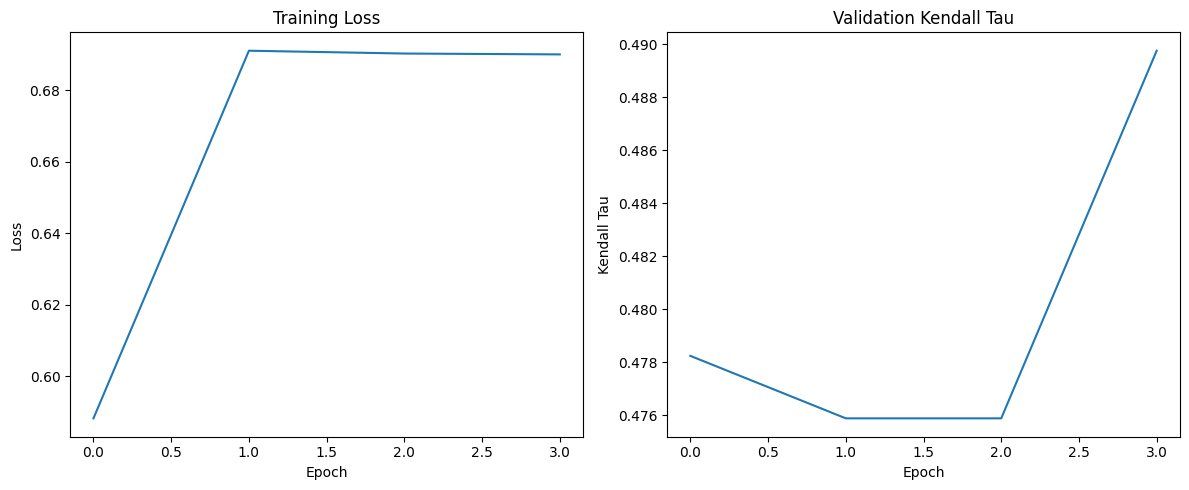

In [27]:

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.subplot(1, 2, 2)
plt.plot(valid_kendalls)
plt.title('Validation Kendall Tau')
plt.xlabel('Epoch')
plt.ylabel('Kendall Tau')

plt.tight_layout()
plt.savefig(os.path.join(savedir, 'training_curves.png'))
plt.show()

In [60]:
# losses = []
losses.append(train_losses[0])
losses

[0.5947136866461864]

In [61]:
# kendals = []
kendals.append(valid_kendalls[0])
kendals

[tensor(0.6770)]

In [63]:
valid_kendalls

[tensor(0.5215), tensor(0.4915)]

In [29]:
# test_dataloader.data

AttributeError: 'DataLoader' object has no attribute 'data'

In [30]:
# NB! нужно тестировать на очень небольшом семпле, остальное кидать в сабмишн

print("*" * 80)
print("Testing model")

best_model_weights = torch.load(f"{savedir}best_model.pt")
model.load_state_dict(best_model_weights)

tester = Tester(model, device)
result = tester.test(test_dataloader)
print(f"Kendall Tau local score: {result}")

********************************************************************************
Testing model


Testing:   0%|          | 5/13926 [00:42<33:07:01,  8.56s/it]


KeyboardInterrupt: 

In [31]:
print("*" * 80)
print("Creating submission file")

best_model_weights = torch.load(f"{savedir}best_model.pt")
model.load_state_dict(best_model_weights)
model.to(device)

def generate_submission(model, device, test_path, submission_path):
    test_files = os.listdir(test_path)
    test_files = [f for f in test_files if f.endswith('.json')]
    
    submission_data = {'id': [], 'cell_order': []}
    
    print(f"Generating predictions for {len(test_files)} test notebooks...")
    
    for test_file in tqdm(test_files, desc="Creating submission"):
        notebook_id = test_file.split('.')[0]
        
        with open(os.path.join(test_path, test_file), 'r') as f:
            notebook = json.load(f)
        
        cell_inputs = []
        cell_ids = []
        
        for cell_id in notebook['source']:
            cell_type = notebook['cell_type'][cell_id]
            source = notebook['source'][cell_id]
            
            if cell_type == 'code':
                tokenizer = code_tokenizer
                cell_type_id = 1
            else:
                tokenizer = text_tokenizer
                cell_type_id = 0
                
            tokens = tokenizer(
                source,
                padding="max_length",
                max_length=config["max_length"],
                truncation=True,
                return_tensors="pt"
            )

            cell_inputs.append({
                'input_ids': tokens['input_ids'],
                'attention_mask': tokens['attention_mask'],
                'cell_type': torch.tensor([cell_type_id], dtype=torch.long)
            })
            cell_ids.append(cell_id)
        
        model.eval()
        with torch.no_grad():
            sorted_ids = []
            for i in range(len(cell_ids) - 1):
                remaining_indices = [j for j in range(len(cell_ids)) if cell_ids[j] not in sorted_ids]
                
                best_score = -float('inf')
                best_index = -1
                
                if i == 0:
                    for idx in remaining_indices:
                        cell_i = cell_inputs[idx]
                        cell_type = cell_i['cell_type'].item()
                        
                        score = -1 if cell_type == 1 else 0
                        
                        if cell_type == 0:
                            source = notebook['source'][cell_ids[idx]]
                            if source.startswith('#') or 'introduction' in source.lower():
                                score += 2
                            
                        if score > best_score:
                            best_score = score
                            best_index = idx
                
                else:
                    prev_cell_idx = cell_ids.index(sorted_ids[-1])
                    prev_cell = cell_inputs[prev_cell_idx]
                    
                    for idx in remaining_indices:
                        curr_cell = cell_inputs[idx]
                        
                        output = model(
                            prev_cell['input_ids'].to(device),
                            prev_cell['attention_mask'].to(device),
                            prev_cell['cell_type'].to(device),
                            curr_cell['input_ids'].to(device),
                            curr_cell['attention_mask'].to(device),
                            curr_cell['cell_type'].to(device)
                        )
                        
                        score = output.item()
                        
                        if score > best_score:
                            best_score = score
                            best_index = idx
                
                sorted_ids.append(cell_ids[best_index])
            
            for remaining_id in cell_ids:
                if remaining_id not in sorted_ids:
                    sorted_ids.append(remaining_id)

        submission_data['id'].append(notebook_id)
        submission_data['cell_order'].append(' '.join(sorted_ids))
    
    submission_df = pd.DataFrame(submission_data)
    submission_df.to_csv(submission_path, index=False)
    print(f"Submission file saved to {submission_path}")
    return submission_df

test_path = "/home/drkocharyan/ai4code/AI4Code/test/"
submission_path = f"{savedir}submission_pair_wise_all.csv"
submission = generate_submission(model, device, test_path, submission_path)

print("\nSample of submission file:")
print(submission.head())


********************************************************************************
Creating submission file
Generating predictions for 4 test notebooks...


Creating submission: 100%|██████████| 4/4 [01:42<00:00, 25.64s/it]


Submission file saved to ./checkpoints/25.03.2025-01.10/submission_pair_wise_all.csv

Sample of submission file:
               id                                         cell_order
0  0028856e09c5b7                eb293dfc 012c9d02 d22526d1 3ae7ece3
1  0010483c12ba9b  7f270e34 54c7cab3 fe66203e 7844d5f8 5ce8863c 4...
2  0010a919d60e4f  584f6568 aafc3d23 80e077ec b190ebb4 322850af e...
3  0009d135ece78d  f9893819 ddfd239c c6cd22db 1372ae9b 90ed07ab 7...


In [ ]:
config = {
    "data_path": "/home/drkocharyan/ai4code/AI4Code/train/",
    "train_orders_path": "/home/drkocharyan/ai4code/AI4Code/train_orders.csv",
    
    "code_model_name": "microsoft/codebert-base",
    "text_model_name": "bert-base-multilingual-uncased",
    
    "train_size": 0.7,
    "valid_size": 0.2,
    "test_size": 0.1,
    "random_seed": 42,
    
    "train_samples": 25000,
    "valid_samples": 5000,
    "test_samples": 2000,
    
    "hidden_dim": 128,
    "dropout_prob": 0.1,
    "max_length": 128,
    
    "batch_size": 64,
    "epochs": 5,
    "early_stopping": 5,
    "saving_freq": 5,
    "learning_rate": 1e-4
}

In [1]:
CONFIG = {
     "data_path": "/home/drkocharyan/ai4code/AI4Code/train/",
    "train_orders_path": "/home/drkocharyan/ai4code/AI4Code/train_orders.csv",
    "train_notebooks_path": "/home/drkocharyan/ai4code/AI4Code/train/",
    
    "random_seed": 42,
    "train_size": 0.7,
    "valid_size": 0.2,
    "test_size": 0.1,
    
    "debug_mode": True,
    "train_sample_size": 50000,
    "valid_sample_size": 5000,
    "test_sample_size": 2000,
    
    "hidden_dim": 128,
    "dropout_prob": 0.1,
    "max_length": 128,
    
    "learning_rate": 1e-4,
    "epochs": 5,
    "batch_size": 1,
    
    "savedir_name": "checkpoints_listwise"
}


In [2]:

# Imports
import pandas as pd
import numpy as np
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from transformers import AutoTokenizer, BertTokenizer, AutoModel, BertModel
from tqdm import tqdm
import os
import json
from bisect import bisect
from time import localtime, strftime
import matplotlib.pyplot as plt


In [6]:
def prepare_folders(savedir_name="checkpoints_listwise"):
    """Prepare folders for saving model checkpoints."""
    current_time = strftime("%d.%m.%Y-%H.%M", localtime())
    savedir = f"./{savedir_name}/{current_time}/"

    if not os.path.exists(f"./{savedir_name}"):
        os.mkdir(f"./{savedir_name}/")
    if not os.path.exists(savedir):
        os.mkdir(savedir)
    else:
        for root, dirs, files in os.walk(savedir, topdown=False):
            for name in files:
                os.remove(os.path.join(root, name))
            for name in dirs:
                os.rmdir(os.path.join(root, name))

    return savedir

def get_device():
    """Get appropriate device for training."""
    device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
    return device

def count_inversions(a):
    """Count the number of inversions in array a."""
    inversions = 0
    sorted_so_far = []
    for i, u in enumerate(a):
        j = bisect(sorted_so_far, u)
        inversions += i - j
        sorted_so_far.insert(j, u)
    return inversions

def kendall_tau(ground_truth, predictions):
    """Calculate the Kendall Tau correlation metric."""
    total_inversions = 0
    total_2max = 0
    for gt, pred in zip(ground_truth, predictions):
        ranks = [gt.index(x) for x in pred]
        total_inversions += count_inversions(ranks)
        n = len(gt)
        total_2max += n * (n - 1)
    return 1 - 4 * total_inversions / total_2max

def custom_collate_fn(batch):
    ids_notebook = [item["id_notebook"] for item in batch]
    
    cell_ids_lists = [item["cell_ids"] for item in batch]
    
    input_ids = [item["input_ids"] for item in batch]
    attention_masks = [item["attention_mask"] for item in batch]
    cell_types = [item["cell_types"] for item in batch]
    
    return {
        "id_notebook": ids_notebook,
        "cell_ids": cell_ids_lists,
        "input_ids": input_ids,
        "attention_mask": attention_masks,
        "cell_types": cell_types
    }


def generate_submission(model, test_dataset, device, output_path='submission.csv'):

    model.eval()
    loader = DataLoader(test_dataset, batch_size=256, shuffle=False, collate_fn=custom_collate_fn)
    
    submission_dict = {}
    
    with torch.no_grad():
        for batch in tqdm(loader, desc="Generating predictions"):
            notebook_id = batch["id_notebook"][0]
            
            if isinstance(batch["cell_ids"], list):
                cell_ids = batch["cell_ids"][0]
            else:
                cell_ids = list(batch["cell_ids"][0])
                
            input_ids = batch["input_ids"][0].to(device)
            att_mask = batch["attention_mask"][0].to(device)
            cell_types = batch["cell_types"][0].to(device)

            scores = model(input_ids, att_mask, cell_types)
            scores_cpu = scores.cpu().numpy()
            
            idx_sorted = np.argsort(-scores_cpu)
            idx_sorted = idx_sorted[:len(cell_ids)]
            
            predicted_ids = [cell_ids[i] for i in idx_sorted]
            submission_dict[notebook_id] = ' '.join(predicted_ids)
    
    submission_df = pd.DataFrame({"id": list(submission_dict.keys()), 
                                 "cell_order": list(submission_dict.values())})
    
    submission_df.to_csv(output_path, index=False)
    print(f"Submission saved to {output_path}")
    
    print("\nSample of submission file:")
    print(submission_df.head())
    
    return submission_df

class ListWiseCellDataset(Dataset):
    def __init__(self, path, data, code_tokenizer, text_tokenizer, max_length=128):
        super().__init__()
        self.path = path
        self.data = data
        self.notebook_ids = list(data.index)
        self.code_tokenizer = code_tokenizer
        self.text_tokenizer = text_tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.notebook_ids)

    def __getitem__(self, idx):
        notebook_id = self.notebook_ids[idx]
        cell_order = self.data.loc[notebook_id, "cell_order"]
        
        if isinstance(cell_order, str):
            cell_order = cell_order.split()
            
        with open(f"{self.path}{notebook_id}.json", "r") as f:
            nb_json = json.load(f)

        input_ids_list = []
        attn_mask_list = []
        cell_type_list = []

        for cell_id in cell_order:
            ctype = nb_json["cell_type"][cell_id]
            csource = nb_json["source"][cell_id]

            if ctype == "code":
                tok = self.code_tokenizer(
                    csource,
                    max_length=self.max_length,
                    padding="max_length",
                    truncation=True,
                    return_tensors="pt"
                )
                cell_type_list.append(1)
            else:  # markdown
                tok = self.text_tokenizer(
                    csource,
                    max_length=self.max_length,
                    padding="max_length",
                    truncation=True,
                    return_tensors="pt"
                )
                cell_type_list.append(0)

            input_ids_list.append(tok["input_ids"].squeeze(0))
            attn_mask_list.append(tok["attention_mask"].squeeze(0))

        input_ids_tensor = torch.stack(input_ids_list, dim=0)
        attn_mask_tensor = torch.stack(attn_mask_list, dim=0)
        cell_type_tensor = torch.tensor(cell_type_list, dtype=torch.long)

        return {
            "id_notebook": notebook_id,
            "cell_ids": cell_order,
            "input_ids": input_ids_tensor,
            "attention_mask": attn_mask_tensor,
            "cell_types": cell_type_tensor
        }
class ListWiseOrderPredictionModel(nn.Module):
    def __init__(self, hidden_dim=768, dropout_prob=0.1):
        super().__init__()
        self.codebert = AutoModel.from_pretrained("microsoft/codebert-base")
        self.bert_text = BertModel.from_pretrained("bert-base-multilingual-uncased")
        self.type_embedding = nn.Embedding(2, 8)

        self.proj = nn.Linear(768 + 8, hidden_dim)
        self.act = nn.ReLU()
        self.dropout = nn.Dropout(dropout_prob)
        self.classifier = nn.Linear(hidden_dim, 1)

    def forward(self, input_ids, attention_mask, cell_types):
        device = input_ids.device
        N = input_ids.size(0)

        code_mask = (cell_types == 1)
        text_mask = (cell_types == 0)

        embeddings = torch.zeros(N, 768, device=device, dtype=torch.float32)

        if code_mask.any():
            code_idx = code_mask.nonzero(as_tuple=True)[0]
            out_code = self.codebert(
                input_ids[code_idx],
                attention_mask=attention_mask[code_idx]
            ).pooler_output
            embeddings[code_idx] = out_code

        if text_mask.any():
            text_idx = text_mask.nonzero(as_tuple=True)[0]
            out_text = self.bert_text(
                input_ids[text_idx],
                attention_mask=attention_mask[text_idx]
            ).pooler_output
            embeddings[text_idx] = out_text

        type_emb = self.type_embedding(cell_types)

        x = torch.cat([embeddings, type_emb], dim=1)
        x = self.dropout(self.act(self.proj(x)))
        scores = self.classifier(x)
        return scores.squeeze(-1)

In [7]:
def listnet_loss(scores, n_items):
    rank_tensor = torch.arange(n_items, device=scores.device, dtype=torch.float32)
    q_unnorm = torch.exp(-rank_tensor)
    q = q_unnorm / q_unnorm.sum()

    p = F.softmax(scores, dim=0)
    eps = 1e-10
    loss = - (q * torch.log(p + eps)).sum()
    return loss

class ListWiseTrainer:
    def __init__(self, model, train_dataset, valid_dataset, device, save_dir, lr=1e-4, epochs=5):
        self.model = model
        self.device = device
        self.epochs = epochs
        self.save_dir = save_dir

        self.train_loader = DataLoader(train_dataset, batch_size=1024, shuffle=True,pin_memory=True, collate_fn=custom_collate_fn)
        self.valid_loader = DataLoader(valid_dataset, batch_size=1024, shuffle=False, pin_memory=True, collate_fn=custom_collate_fn)

        self.optimizer = torch.optim.AdamW(self.model.parameters(), lr=lr)
        self.best_kendall = -999.0
        self.best_model_state = None
        
        self.train_losses = []
        self.valid_kendalls = []

    def train(self):
        self.model.to(self.device)
        for epoch in range(1, self.epochs+1):
            print(f"\nEpoch [{epoch}/{self.epochs}]")
            train_loss = self._train_one_epoch()
            val_kendall = self._validate()
            
            self.train_losses.append(train_loss)
            self.valid_kendalls.append(val_kendall)
            
            print(f"Train loss: {train_loss:.4f}, Valid Kendall Tau: {val_kendall:.4f}")

            if val_kendall > self.best_kendall:
                self.best_kendall = val_kendall

                self.best_model_state = {
                    k: v.cpu() for k, v in self.model.state_dict().items()
                }
                print("New best model saved.")

        if self.best_model_state is not None:
            torch.save(self.best_model_state, os.path.join(self.save_dir, "best_model.pt"))
            print(f"Best model with Kendall Tau={self.best_kendall:.4f} saved.")
            
        return self.train_losses, self.valid_kendalls

    def _train_one_epoch(self):
        self.model.train()
        total_loss = 0.0
        n_batches = 0

        for batch in tqdm(self.train_loader, desc="Training"):
            self.optimizer.zero_grad()
            input_ids = batch["input_ids"][0].to(self.device)
            att_mask  = batch["attention_mask"][0].to(self.device)
            cell_types= batch["cell_types"][0].to(self.device)
            N = input_ids.size(0)

            scores = self.model(input_ids, att_mask, cell_types)
            loss = listnet_loss(scores, N)
            loss.backward()
            self.optimizer.step()

            total_loss += loss.item()
            n_batches += 1

        return total_loss / max(1, n_batches)

    def _validate(self):
        self.model.eval()
        all_gt_orders = []
        all_pred_orders = []

        with torch.no_grad():
            for batch in self.valid_loader:
                notebook_id = batch["id_notebook"][0]
                
                if isinstance(batch["cell_ids"], list):
                    cell_ids = batch["cell_ids"][0]
                else:
                    cell_ids = list(batch["cell_ids"][0])
                
                input_ids = batch["input_ids"][0].to(self.device)
                att_mask = batch["attention_mask"][0].to(self.device)
                cell_types = batch["cell_types"][0].to(self.device)

                scores = self.model(input_ids, att_mask, cell_types)
                scores_cpu = scores.cpu().numpy()

                idx_sorted = np.argsort(-scores_cpu)
                idx_sorted = idx_sorted[:len(cell_ids)]
                
                predicted_ids = [cell_ids[i] for i in idx_sorted]

                all_gt_orders.append(list(cell_ids))
                all_pred_orders.append(predicted_ids)

        ktau = kendall_tau(all_gt_orders, all_pred_orders)
        return ktau

class ListWiseTester:
    def __init__(self, model, device):
        self.model = model
        self.device = device
    
    def test(self, test_dataset):
        loader = DataLoader(test_dataset, batch_size=256, shuffle=False, collate_fn=custom_collate_fn)
        all_gt_orders = []
        all_pred_orders = []

        self.model.eval()
        with torch.no_grad():
            for batch in loader:
                if isinstance(batch["cell_ids"], list):
                    cell_ids = batch["cell_ids"][0]
                else:
                    cell_ids = list(batch["cell_ids"][0])
                    
                input_ids = batch["input_ids"][0].to(self.device)
                att_mask = batch["attention_mask"][0].to(self.device)
                cell_types = batch["cell_types"][0].to(self.device)

                scores = self.model(input_ids, att_mask, cell_types)
                scores_cpu = scores.cpu().numpy()
                
                idx_sorted = np.argsort(-scores_cpu)
                idx_sorted = idx_sorted[:len(cell_ids)]
                
                predicted_ids = [cell_ids[i] for i in idx_sorted]

                all_gt_orders.append(list(cell_ids))
                all_pred_orders.append(predicted_ids)

        ktau = kendall_tau(all_gt_orders, all_pred_orders)
        return ktau


In [8]:
# test_data

In [9]:
np.random.seed(42)
# Load and split data
info = pd.read_csv(CONFIG["train_orders_path"], index_col="id")
info["cell_order"] = info["cell_order"].apply(lambda x: x.split())
indeces = list(info.index)

rng = np.random.default_rng(CONFIG["random_seed"])
rng.shuffle(indeces)

train_border = int(CONFIG["train_size"] * len(indeces))
valid_border = int((CONFIG["train_size"] + CONFIG["valid_size"]) * len(indeces))

train_data = info.loc[indeces[:train_border]]
valid_data = info.loc[indeces[train_border:valid_border]]
test_data  = info.loc[indeces[valid_border:]]

if CONFIG["debug_mode"]:
    train_data = train_data.iloc[:CONFIG["train_sample_size"]]
    valid_data = valid_data.iloc[:CONFIG["valid_sample_size"]]
    test_data  = test_data.iloc[:CONFIG["test_sample_size"]]


In [10]:
train_data

,cell_order
id,
a80c1fed7cf1b7,"[efd93fd9, 8b5f324d, 44f08ea5, 8a28a172, 4257e..."
140ec0d92d8e67,"[e1df203d, 1471043e, 59056883, 8e8b37a5, ae7f9..."
bdefc690c0fb8f,"[deee4a89, f83238cc, 432ca17b, 16636875, c33d3..."
e27d3ad8c97864,"[05b42c18, b356682f, 343077ac, b38bd196, f9737..."
70ffc5d9108413,"[364c7354, ffbf800f, 60f5134b, 8e4d61aa, 40136..."
...,...
6e7ae6fc2a04a0,"[315db33b, be37e434, 79e6e87e, a8a0328e, 29c49..."
f5f3b825bd5303,"[212694c3, 1b687f61, f51dc9c3, 818affe1, 7d502..."
07ef1fbaa82bda,"[4e3d8d9d, 35a3d91e, d7378950, c5640526, 99c64..."


In [11]:
np.random.seed(42)
# Load and split data

code_tokenizer = AutoTokenizer.from_pretrained("microsoft/codebert-base")
text_tokenizer = BertTokenizer.from_pretrained("bert-base-multilingual-uncased")

info = pd.read_csv(CONFIG["train_orders_path"], index_col="id")
info["cell_order"] = info["cell_order"].apply(lambda x: x.split())
indeces = list(info.index)

rng = np.random.default_rng(CONFIG["random_seed"])
rng.shuffle(indeces)

train_border = int(CONFIG["train_size"] * len(indeces))
valid_border = int((CONFIG["train_size"] + CONFIG["valid_size"]) * len(indeces))

train_data = info.loc[indeces[:train_border]]
valid_data = info.loc[indeces[train_border:valid_border]]
test_data  = info.loc[indeces[valid_border:]]

if CONFIG["debug_mode"]:
    train_data = train_data.iloc[:CONFIG["train_sample_size"]]
    valid_data = valid_data.iloc[:CONFIG["valid_sample_size"]]
    test_data  = test_data.iloc[:CONFIG["test_sample_size"]]

print(f"Train size: {len(train_data)}")
print(f"Valid size: {len(valid_data)}")
print(f"Test size: {len(test_data)}")

train_dataset = ListWiseCellDataset(
    path=CONFIG["train_notebooks_path"],
    data=train_data,
    code_tokenizer=code_tokenizer,
    text_tokenizer=text_tokenizer,
    max_length=CONFIG["max_length"]
)

valid_dataset = ListWiseCellDataset(
    path=CONFIG["train_notebooks_path"],
    data=valid_data,
    code_tokenizer=code_tokenizer,
    text_tokenizer=text_tokenizer,
    max_length=CONFIG["max_length"]
)

test_dataset = ListWiseCellDataset(
    path=CONFIG["train_notebooks_path"],
    data=test_data,
    code_tokenizer=code_tokenizer,
    text_tokenizer=text_tokenizer,
    max_length=CONFIG["max_length"]
)

Train size: 50000
Valid size: 5000
Test size: 2000


In [12]:
model = ListWiseOrderPredictionModel(
    hidden_dim=CONFIG["hidden_dim"], 
    dropout_prob=CONFIG["dropout_prob"]
)
savedir = prepare_folders(savedir_name=CONFIG["savedir_name"])
device = get_device()

In [13]:
from torch.nn import DataParallel

# Перемещение модели на несколько GPU
if torch.cuda.device_count() > 1:
    print(f"Используется {torch.cuda.device_count()} GPU!")
    model = DataParallel(model)

# Перемещение модели на устройство (GPU)
model.to(device)


Используется 4 GPU!


In [ ]:

trainer = ListWiseTrainer(
    model=model,
    train_dataset=train_dataset,
    valid_dataset=valid_dataset,
    device=device,
    save_dir=savedir,
    lr=CONFIG["learning_rate"],
    epochs=2
)
train_losses, valid_kendalls = trainer.train()



Epoch [1/2]


Training:  69%|██████▉   | 34/49 [37:41<18:34, 74.31s/it]

In [16]:
valid_kendalls

[0.15651656417377502]

In [17]:
tester = ListWiseTester(model, device)
result = tester.test(test_dataset)

In [18]:
train_losses

[2.9877079944221343]

In [19]:
valid_kendalls

[0.15651656417377502]

In [ ]:

trainer = ListWiseTrainer(
    model=model,
    train_dataset=train_dataset,
    valid_dataset=valid_dataset,
    device=device,
    save_dir=savedir,
    lr=CONFIG["learning_rate"],
    epochs=1
)
train_losses, valid_kendalls = trainer.train()


In [ ]:

trainer = ListWiseTrainer(
    model=model,
    train_dataset=train_dataset,
    valid_dataset=valid_dataset,
    device=device,
    save_dir=savedir,
    lr=CONFIG["learning_rate"],
    epochs=7
)
train_losses, valid_kendalls = trainer.train()



Epoch [1/7]


Training:  89%|████████▉ | 174/196 [21:56<02:48,  7.64s/it]

In [ ]:
tester = ListWiseTester(model, device)
result = tester.test(test_dataset)

In [ ]:
# 50k 5k 2k 8 epochs
train_losses

In [ ]:
valid_kendalls

In [ ]:

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.subplot(1, 2, 2)
plt.plot(valid_kendalls)
plt.title('Validation Kendall Tau')
plt.xlabel('Epoch')
plt.ylabel('Kendall Tau')

plt.tight_layout()
plt.savefig(os.path.join(savedir, 'training_curves.png'))
plt.show()

best_model_path = os.path.join(savedir, "best_model.pt")
best_weights = torch.load(best_model_path, map_location="cpu")
model.load_state_dict(best_weights)
model.to(device)

tester = ListWiseTester(model, device)
result = tester.test(test_dataset)
print("*"*80)
print(f"Test Kendall Tau score: {result:.4f}")


submission_output_path = os.path.join(savedir, "submission.csv")
submission_df = generate_submission(model, test_dataset, device, output_path=submission_output_path)

if CONFIG["debug_mode"]:
    print("\nNote: This submission was generated in debug mode with a small test sample.")
    print("To create a full submission, set 'debug_mode': False in the configuration.")
